# ModelFlow, a toolkit
Python is an incredible and versatile language embedded a powerful ecosystem. For data
science 
the Pandas library is a powerful "Swiss Army Knife".

In economic and for modeling banks we need  **lagged variables**
and **simultaneous formulas** (circular references in Excel speak).

ModelFlow, a toolkit to enable  lagged variables and simultaneous formulas.

This notebook ModelFlow to extend dataframes. Other notebooks show ModelFlow as a class. 

# Jupyter

This is a Jupyter notebook. Jupyter is a Python Shell 

You will notice **input cells** (marked:In\[\]) and **output cells** (marked: Out\[\]) 

It is live, so you can try it out yourself, if you have access to the
ModelFlow toolkit, else you just have to watch.

This Jupyter notebook show how ModelFlow can extend pandas dataframes to run models. 

The notebook focus on a simple example and do not explore all the features and
options. Also the models are toy models created to be small but still illustrative.

# Import stuff

In [18]:
import pandas as pd               # Python data science library
import sys
from IPython.display import SVG, display
import modelmf     # This will extend pandas dataframes with ModelFlow 

# Create a Pandas Dataframe
We make up some data.

Pandas dataframes are tables with **row** and **column** names. Columns are variables, and rows are the time dimension. 

In [19]:

df = pd.DataFrame({'LOAN': [100,0,0,0],'SECURITIES': [10,11,12,13],
                   'CASH': [4,4,4,4],         'DEPOSIT'  : [100,100,100,100],
                   'BONDS':[1,2,3,10],         'NEW_LOAN' :  [1,20,30,40] },
                  index=[2018,2019,2020,2021])
df

,LOAN,SECURITIES,CASH,DEPOSIT,BONDS,NEW_LOAN
2018,100,10,4,100,1,1
2019,0,11,4,100,2,20
2020,0,12,4,100,3,30
2021,0,13,4,100,10,40


# A model, where Pandas don't work out of the box 
A very small stylized dynamic model of the balance sheet of a bank is created. 

In [20]:
fmodel = '''\
£ Stock
ASSETS  = LOAN + SECURITIES + CASH
FUNDING = DEPOSIT + BONDS
EQUITY  = ASSETS - FUNDING 
LIABILITIES = FUNDING + EQUITY 

£ stock flow
DEPOSIT   = DEPOSIT(-1) + NEW_DEPOSIT
LOAN      = LOAN(-1)+  NEW_LOAN 
NEW_BONDS =  (NEW_LOAN - NEW_DEPOSIT) 
BONDS     = BONDS(-1) + NEW_BONDS'''

# Apply the model on the dataframe.

To do this we use dataframe.mfcalc.

In [21]:
df.mfcalc(fmodel)

,LOAN,SECURITIES,CASH,DEPOSIT,BONDS,NEW_LOAN,ASSETS,FUNDING,NEW_BONDS,EQUITY,LIABILITIES,NEW_DEPOSIT
2018,100.0,10.0,4.0,100.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019,120.0,11.0,4.0,100.0,21.0,20.0,135.0,121.0,20.0,14.0,135.0,0.0
2020,150.0,12.0,4.0,100.0,51.0,30.0,166.0,151.0,30.0,15.0,166.0,0.0
2021,190.0,13.0,4.0,100.0,91.0,40.0,207.0,191.0,40.0,16.0,207.0,0.0


# Notice:
* The model is run from 2019. It cant run 2018 as as there is no values for laggged variables in 2018. 
* The model is calculated even when the formulas where not in the logical order. 
* Variables in the model missing from the dataframe are set to 0

# There is more 
The result from a model run can be used straight in python programs.

But, A model instance ```<dataframe>.mf``` contains

*  The first and last solution of the model
*  The directed graph of which variable contributes to which variable
*  All formulas in the model 

This makes it a powerful tool for model and result analysis.

# Make another experiment 
First we update some exogenous variables (variables which are only on the right hand side of the model). Then we run the model again. 

In [22]:
df['NEW_LOAN']= [1,40,50,80]
df['NEW_DEPOSIT']= [1,30,25,50]
df.mfcalc(fmodel)

,LOAN,SECURITIES,CASH,DEPOSIT,BONDS,NEW_LOAN,NEW_DEPOSIT,ASSETS,FUNDING,NEW_BONDS,EQUITY,LIABILITIES
2018,100.0,10.0,4.0,100.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2019,140.0,11.0,4.0,130.0,11.0,40.0,30.0,155.0,141.0,10.0,14.0,155.0
2020,190.0,12.0,4.0,155.0,36.0,50.0,25.0,206.0,191.0,25.0,15.0,206.0
2021,270.0,13.0,4.0,205.0,66.0,80.0,50.0,287.0,271.0,30.0,16.0,287.0


# Visualizing 
The results can be compared and visualized. 

Wildcards can be used to select the variables to visualize.

If this is not sufficient the whole suite of Python visualization (as Matplotlib, Seaborn, Plotly) can be used on top of the resulting dataframes. 

# Plot the last result

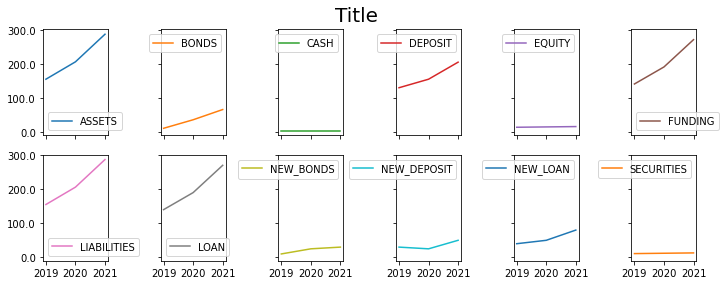

In [23]:
_ = df.mf['*'].plot()

# Plot the difference between the first and last run 

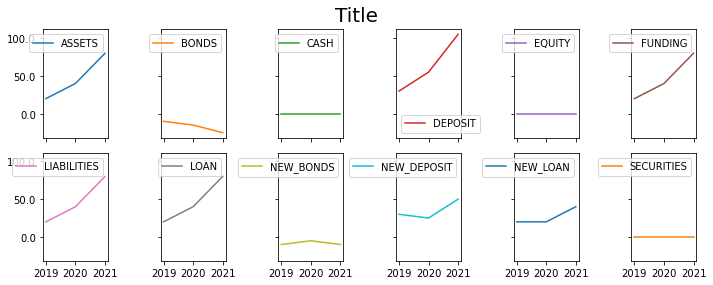

In [24]:
_ = df.mf['*'].dif.plot()

# Or as heatmap 

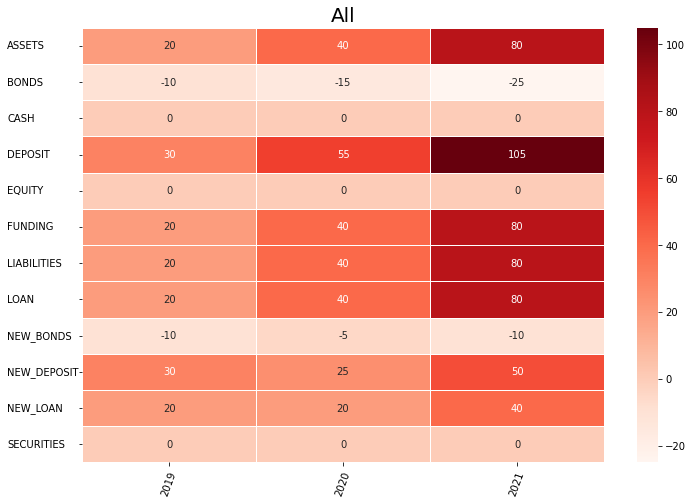

In [25]:
_ = df.mf[['*']].dif.heat(title='All',annot=True)

# The stucture of the model (dependency graph)

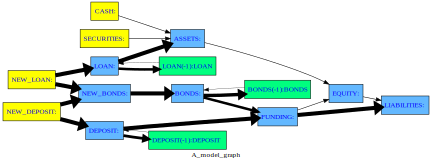

In [26]:
df.mf.drawmodel()

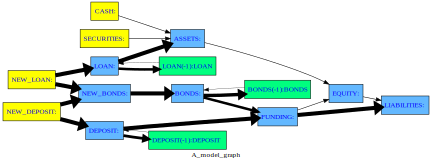

In [27]:
df.mf.drawmodel(all =1,svg=1) 

# What explains the difference for a variable 
Which of the input variables explains the difference of the results of a formula between two runs.

If we have:

$y = f(a,b)$

and we have two solutions where the variables differs by $\Delta y, \Delta a, \Delta b$

How much of $\Delta y$ can be explained by $\Delta a$ and $\Delta b$ ?

Analytical the attributions $\Omega a$ and $\Omega b$ can  be calculated like this: 

$\Delta y = \underbrace{\Delta a \frac{\partial {f}}{\partial{a}}(a,b)}_{\Omega a} + 
\underbrace{\Delta b \frac{\partial {f}}{\partial{b}}(a,b)}_{\Omega b}+Residual$

If we have two experiments:

\begin{eqnarray}  
y_0&=&𝑓(a_{0},b_{0}) \\
y_1&=&𝑓(a_0+\Delta a,b_{0}+ \Delta b)
\end{eqnarray}

ModelFlow will do a numerical approximation of $\Omega a$ and $\Omega b$.

\begin{eqnarray}  
\Omega f_a&=&f(a_1,b_1 )-f(a_1-\Delta a,b_1) \\
\Omega f_b&=&f(a_1,b_1 )-f(a_1,b_1-\Delta  b)
\end{eqnarray}



If the model is fairly linear, the residual will be small. 

\begin{eqnarray}
residual = \Omega f_a + \Omega f_b -(y_1 - y_0) 
\end{eqnarray}

Now look at generations of attributions 

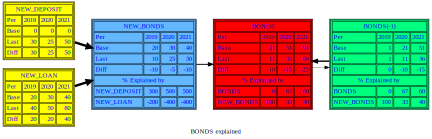

In [28]:
_= df.mf.bonds.explain(up=2,HR=0,pdf=0)

# Beyond a simpel model

This was a simple model. You don't even need a computer to solve it, or you could use Excel to handle the model.  However sometime you want to:

* Invert the model to solve for targets as function of instruments.
* Use a a more rich business logic language
* Let variables be matrices (dense or sparse) 
* Scale to large model (even millions of equations)
* Handle simultaneous models
* Make identical models for a lot of banks/sectors or whatever
* Solve models fast  
* Grab a model from Matlab/Dynare/Excel/Latex
* Attribute difference between scenarios to individual variables or groups of variables.
* Speed up the model by compiling the model 
* Linearize the model using symbolic differentiation 
* Calculate stability of a linearized model. 